# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Bailey Belinger, Camila Monter, Priya Shah

**ID**: 5277347 (bcb87), 5244508 (ps746), 5244001 (cm755)

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/HW-2/hw2-last-three-brain-cells`


In [4]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

We will begin our derivation with the general advection-dispersion equation in steady-state conditions: $v \frac{dC}{dx} = -k C$ where v is velocity of the river in km/d, $ \frac{dC}{dx}$ is the rate of change of CRUD concentration with respect to distance, and kC is the change in CRUD due to exponential decay.

We will now solve this differential equation to solve for C, the concentration at any point in the river (x):

Rearranging terms to group variables on the same side of the equals sign

$ \frac{dC}{C} = - \frac{k}{v}dx$

Integrating

$\int \frac{1}{C} \, dC = -\frac{v}{k} \int dx$

lnC = $ \frac{k}{v}x + constant $

Exponentiating to solve for C and rewriting constant as $C_0$, where $C_0$ is the initial concentration of CRUD in the river inflow

$C = e^{-\frac{v}{k} x + \text{constant}}$

We arrive at the general form of equation for concentration of CRUD at any point x downstream in the river based on one input and one initial

$C(x) = C_0e^{-\frac{v}{k}x}$

We must now apply this equation to our given boundary conditions, for the initial river inflow, discharge #1, and discharge #2.

The concentration of the intial river inflow is given as $C_{\text{initial}} = 0.5 kg / 1000m^{3}$

The concentration from discharge #1 (at x=0) can be defined as $C_{1}$ and the concentration from discharge #2 (at x = 15) can be defined as $C_{2}$.

Combining the general form of the decay concentration derived above for the three inputs into the river we arrive at the following:

$C(x) = C_1 e^{-0.036 x} + C_2 e^{-0.036 (x - 15)} + C_{\text{initial}} e^{-0.036 x}$

Recall that the decay constant k was stated in the problem to be 0.36 / day and the river velocity v to be 10 km / day. Therefore, inputting those values into their respective variables we arrive at an exponent of = $ - \frac{k}{v} = - \frac{0.36}{10} = 0.036$

However, this equation is only applicable after and at the second discharge point (x = 15 km). Any point before this must only consider the initial concentration and discharge #1 of SCUM.

So for x = 0 km to x = 15 km, we must implement the following:

$C(x) = C_1 e^{-0.036 x} + C_{\text{initial}} e^{-0.036 x}$

In order to determine if the system is in compliance with the regulatory limit of $2.5 kg/(1000 m^{3})$ we must write a function that outputs the concentration at a given distance downriver.

In [30]:
function CRUD_conc(x)
    C1 = 9;
    C2 = 7;
    Ci = 0.5;
    if x >= 15
        C = C1*exp(-0.036*x) + C2*exp(-0.036*(x-15)) + Ci*exp(-0.036*x)
    else
        C = x = C1*exp(-0.036*x) + Ci*exp(-0.036*x)
    end
    if C > 2.5
        print("System is not in compliance with regulatory limit.")
    end
    return C
end

x = 16
@show CRUD_conc(x)

System is not in compliance with regulatory limit.CRUD_conc(x) = 12.092835283751674


12.092835283751674

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

In [27]:
b = 0.5
q = 1.5
yt = 0
a = 0

# define functions for lake recycling and outflows
function X_outflow(X,b)
    outflow = b*X
    return outflow
end

function X_recycling(X,q)
    recyling = (abs(X)^q)/(1+abs(X)^q)
    return recyling
end

function X_delta(X, a, b, q)
    output = a + X_recycling(X, q) - X_outflow(X, b)
    return output
end

# Compute X_delta for each value in X_vals
# Note: You need to specify X; using X_vals here for simplicity.
# X_map = map(x -> X_delta(x, a, X, b, q), X_vals)

x01 = 0.8
x02 = 0.1
root1 = Roots.find_zero(x -> X_delta(x, a, b, q), x01)
root2 = Roots.find_zero(x -> X_delta(x, a, b, q), x02)
display(root1)
display(root2)

T = 30
X_vals = collect(0.0:0.1:1.5)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ X_recycling(X[t-1], q) .- X_outflow(X[t-1], b)
    end
    return X
end
X = map(x -> simulate_lake_P(x, T, 0.4, 2.5, zeros(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500), left_margin=5, bottom_margin=5)

1.0

0.0

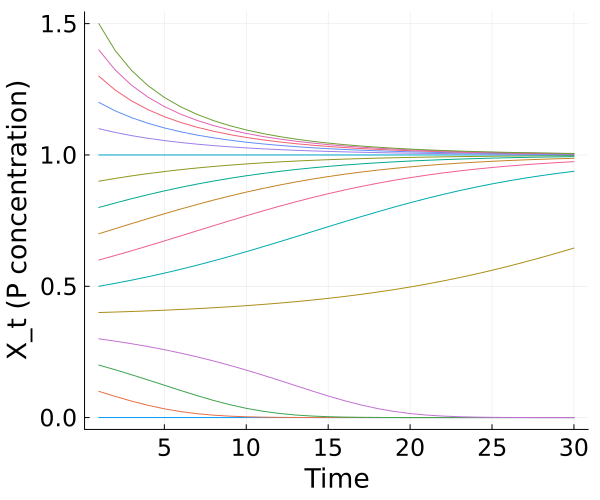

In [9]:
using Plots

# Define outflow and recycling functions
function X_outflow(X, b)
    return b * X
end

function X_recycling(X, q)
    return X^q / (1 + X^q)
end

# Simulate the lake P model over T time steps
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] + a[t] + y[t] + X_recycling(X[t-1], q) - X_outflow(X[t-1], b)
    end
    return X
end

# Set up initial conditions
T = 30  # Time steps
X_vals = collect(0.0:0.1:1.5)  # Range of initial conditions
a = zeros(T)  # a_t = 0
y = zeros(T)  # y_t = 0

# Run simulations for each initial condition in X_vals
X_traj = [simulate_lake_P(X_ic, T, 0.5, 1.5, a, y) for X_ic in X_vals]

# Plot the trajectories
p = plot(legend=false, ylabel="X_t (P concentration)", xlabel="Time", 
         guidefontsize=18, tickfontsize=16, size=(600, 500))

for X in X_traj
    plot!(p, X)
end

display(p)



### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.